# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [4]:
example_document = index.document(index.document_base())
type(example_document[1])

tuple

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [5]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [6]:
print([id2token[word_id] for word_id in set(example_document[1]) if word_id > 0])

['fifty', 'new', 'two', '1', 'percent', 'million', '000', 'safety', 'years', 'state', 'decide', 'time', 'officials', 'police', 'duffey', '5', 'american', 'told', '35', 'tuesday', 'city', 'promotes', 'wednesday', 'monday', 'mario', '23', 'york', 'department', 'demands', '6', 'occupying', 'halt', 'military', 'amherst', 'make', 'issued', 'union', 'spokesman', 'declined', 'trespassing', 'occupation', 'work', 'members', '300', 'militarism', 'staff', 'public', 'chanting', 'route', 'office', 'contended', 'leaving', 'overnight', 'reduced', 'purpose', 'money', 'committee', 'incident', 'hall', 'defense', 'telling', 'school', 'demonstrators', 'later', 'administration', 'service', 'deciccio', 'meeting', 'spokeswoman', 'began', 'dangerous', 'provosts', 'question', 'hearing', 'campus', 'm', 'negotiated', 'occupied', 'board', 'bus', 'rallying', 'left', 'second', 'lying', 'set', 'college', 'protesters', 'came', '11', '25', 'students', 'd', 'suspend', 'statement', 'university', 'increases', 'student', 

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [7]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [8]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [9]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [64]:
# libraries
import time
import numpy as np
import math
import collections
from collections import Counter
from collections import defaultdict
from operator import itemgetter
from pprint import pprint
import copy
import gensim
import logging
import pyndri.compat
import sys
import Cython
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
np.random.seed(12345678) 

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

INFO:root:test


In [11]:
#with open('./ap_88_89/test_topic', 'r') as f_topics:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

start_time = time.time()
# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

#______________________we added a list to keep the ext_doc and the tokens in every doc___________
doc_list = []
max_doc_len = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    
    #--------------------------------------
    doc_list.append((ext_doc_id,doc_token_ids))
    if(len(doc_token_ids) > max_doc_len):
        max_doc_len = len(doc_token_ids)
    
    #--------------------------------------
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 41.30068874359131 seconds.


In [12]:
def get_tf(int_document_id, query_term_id):
    #Returns term frequency (tf_t) for a document
    return float(inverted_index.get(query_term_id, 0).get(int_document_id, 0))

def collection_freq(query_term_id):
    #Returns collection frequency
    return collection_frequencies.get(query_term_id, 0)

def calc_p_wc(query_term_id):
    #Returns background probability p(w|C)
    tf_wC = collection_freq(query_term_id)
    C = total_terms
    return (tf_wC/C)

In [13]:
def run_retrieval(model_name, score_fn, hyper_param):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    #-----------------------------------------
    if model_name != 'tfidf' and model_name != 'BM25':
        model_name = model_name + str(hyper_param)
    #-----------------------------------------
    run_out_path = str('models/') + '{}.run'.format(model_name)

#    if os.path.exists(run_out_path):
#        return

    retrieval_start_time = time.time()


    print('Retrieving using', model_name)

    data = collections.defaultdict(list)
    top1000data = collections.defaultdict(list)

    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    #for query_id, _ in queries.items():
    for query_id, query_terms in tokenized_queries.items():
        
        score_per_doc = Counter()
        '''
        We do not go through all documents, we just go through the all documents relate to query term.
        For example if we have 5 docs and Q1 = w1 w2 and w1 is inside the doc1 & doc2, w2 is inside doc3
        , then we go through doc1, doc2, doc3
        '''        
        #------------------------docs_to_check = sum of all documents for q:-------------------------
        
        docs_to_check = set([inverted_index[term_id].keys() for term_id in query_terms][0])
        
        '''
        We check the score for every term of a query for every doc related to that query and assign some score
        to them.
        In tf-idf when the term is not inside the that doc, we return 0.
        In the smoothing methods, we assign some probability to the unseen terms.
        '''
        #--------------------------find the score(query, doc)-----------------------------------------
        #for query_term_id in tokenized_queries[query_id]:
        for query_term_id in query_terms:
            for int_doc_id in docs_to_check:
                document_term_freq = get_tf(int_doc_id, query_term_id)
                score_per_doc[int_doc_id] += score_fn(int_doc_id, query_term_id, document_term_freq, hyper_param)
                
        #------------------------make data set to write in run file------------------------------------        
        for int_doc_id in score_per_doc:
            data[query_id].append((score_per_doc[int_doc_id], doc_list[int_doc_id - 1][0]))
#         sorted_score = sorted(data[query_id], key = itemgetter(0), reverse=True)
        
#         if model_name == 'tfidf':
#             top1000data[query_id] = sorted_score
#             del top1000data[query_id][:1000] 

#         print(query_id, ': ' ,top1000data[query_id][:10])
    print('Retrieval took: ', time.time() - retrieval_start_time, 'seconds.')
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000) 

#### TF - IDF

In [14]:
def tfidf(int_document_id, query_term_id, document_term_freq, num_docs):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """    
    score = document_term_freq * math.log10(num_docs/len(inverted_index[query_term_id]))
    return score

num_documents = index.maximum_document() - index.document_base()
run_retrieval('tfidf', tfidf, num_documents)

Retrieving using tfidf
Retrieval took:  6.376723051071167 seconds.


#### BM25

In [15]:
hyper_param = [1.2,0.75]
'''    
k1=1.2
b=0.75
'''
def BM25(int_document_id, query_term_id, document_term_freq,hyper_param):

    '''
    BM25 with document length normalization
    tf = document_term_freq
    l_avg = avg_doc_length
    l_d = document_lengths[int_document_id]
    idf = math.log10(num_documents/len(inverted_index[query_term_id])
    '''
    k1=hyper_param[0]
    b=hyper_param[1]


    w_t_numerator = (k1+1) * document_term_freq * math.log10(num_documents / len(inverted_index[query_term_id]))
    w_t_denominator = (k1 * (1-b + (b * document_lengths[int_document_id] / avg_doc_length))) + document_term_freq

    w_t =  w_t_numerator/w_t_denominator
    
    return w_t
run_retrieval('BM25', BM25, hyper_param)

Retrieving using BM25
Retrieval took:  9.23710036277771 seconds.


#### Jelinek-Mercer at 𝛌 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [16]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, lmbda):
    
    tf_wd = document_term_freq
    d = document_lengths[int_document_id]
    p_wC = calc_p_wc(query_term_id)

    pbt_lambda = (1 - lmbda)*(p_wC) + lmbda*(tf_wd/d)
    return np.log10(pbt_lambda)

In [17]:
for hyper_param in np.arange(0, 1, 0.1): 
    hyper_param = round(hyper_param, 1)
    run_retrieval('jelinek_mercer ', jelinek_mercer, hyper_param)

Retrieving using jelinek_mercer 0.0
Retrieval took:  19.029163360595703 seconds.
Retrieving using jelinek_mercer 0.1
Retrieval took:  16.72562074661255 seconds.
Retrieving using jelinek_mercer 0.2
Retrieval took:  18.553688049316406 seconds.
Retrieving using jelinek_mercer 0.3
Retrieval took:  18.229533433914185 seconds.
Retrieving using jelinek_mercer 0.4
Retrieval took:  17.92137837409973 seconds.
Retrieving using jelinek_mercer 0.5
Retrieval took:  16.644779205322266 seconds.
Retrieving using jelinek_mercer 0.6
Retrieval took:  16.536654472351074 seconds.
Retrieving using jelinek_mercer 0.7
Retrieval took:  17.420358180999756 seconds.
Retrieving using jelinek_mercer 0.8
Retrieval took:  16.922592878341675 seconds.
Retrieving using jelinek_mercer 0.9
Retrieval took:  16.888097524642944 seconds.


#### Absolute Discounting at 𝛅 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [18]:
#formula from : https://dl.acm.org/citation.cfm?id=384019
def absolute_discounting(int_document_id, query_term_id, document_term_freq, delta):
    
    tf_wd = document_term_freq
    d = document_lengths[int_document_id]
    #d_u = number of unique words in d
    d_u = unique_terms_per_document[int_document_id]
    p_wC = calc_p_wc(query_term_id)
    
    #seen words probability
    seen_words = max((tf_wd - delta), 0)/d
    
    #unseen words probability
    unseen_words = delta*(d_u/d)*p_wC

    return (seen_words + unseen_words)

for hyper_param in np.arange(0, 1, 0.1):
    hyper_param = round(hyper_param, 1)
    run_retrieval('absolute_discounting ', absolute_discounting, hyper_param)
#run_retrieval('absolute_discounting 0.5', absolute_discounting_05)
#run_retrieval('absolute_discounting 0.9', absolute_discounting_09)

Retrieving using absolute_discounting 0.0
Retrieval took:  11.780969619750977 seconds.
Retrieving using absolute_discounting 0.1
Retrieval took:  12.02707576751709 seconds.
Retrieving using absolute_discounting 0.2
Retrieval took:  11.306993961334229 seconds.
Retrieving using absolute_discounting 0.3
Retrieval took:  11.250715017318726 seconds.
Retrieving using absolute_discounting 0.4
Retrieval took:  11.84693455696106 seconds.
Retrieving using absolute_discounting 0.5
Retrieval took:  12.099369049072266 seconds.
Retrieving using absolute_discounting 0.6
Retrieval took:  13.318758487701416 seconds.
Retrieving using absolute_discounting 0.7
Retrieval took:  12.30607295036316 seconds.
Retrieving using absolute_discounting 0.8
Retrieval took:  13.914846897125244 seconds.
Retrieving using absolute_discounting 0.9
Retrieval took:  12.045928955078125 seconds.


### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [19]:
#first obtain an initial top-1000 ranking for each query using TF-IDF in Task 1
docx = {}
keys = inverted_index.keys()
start_time = time.time()

print('Computing took: ')

for k in keys:
    docx[k] = inverted_index[k].keys()

scores = {}
top1000_tfidf = {}

#create datasets to store scores and document ids separately
for query_id, term_idx in tokenized_queries.items():
    scores[query_id] = []
    docx_set = set()

    for term_id in term_idx:
        docx_set = docx_set | set(docx[term_id])

#compute tfids scores
    for d_id in docx_set:
        result = 0
        for term_id in term_idx:
            result += tfidf(d_id, term_id, len(inverted_index.get(term_id, 0)), num_documents)
        scores[query_id].append((result, index.document(d_id)[0], d_id))  

print(time.time() - start_time, 'seconds.')

Computing took: 
109.03705310821533 seconds.


In [20]:
#store top 1000 tfidf rank queries
for query_id, term_idx in tokenized_queries.items():
    top1000_tfidf[query_id] = sorted(scores[query_id], key = itemgetter(0), reverse = True)
    del top1000_tfidf[query_id][1000:]

#pprint(top1000_tfidf)

In [21]:
'''
#read from tfidf run file [query id no. ---- score]

Masoumeh, this doesn't work as reading from files like this doesn't generate the .run file in the TREC format 
and raises errors. Hence I'm reimplementing the above function to compute the top1000 tfidf scores for each query

tfidf_file = open('models/tfidf.run', 'r')
top1000_tfidf = collections.defaultdict(list)

for line in tfidf_file:
    top1000_tfidf=line.split()
     top1000_tfidf[info[0]].append(info[4])  
'''

"\n#read from tfidf run file [query id no. ---- score]\n\nMasoumeh, this doesn't work as reading from files like this doesn't generate the .run file in the TREC format \nand raises errors. Hence I'm reimplementing the above function to compute the top1000 tfidf scores for each query\n\ntfidf_file = open('models/tfidf.run', 'r')\ntop1000_tfidf = collections.defaultdict(list)\n\nfor line in tfidf_file:\n    top1000_tfidf=line.split()\n     top1000_tfidf[info[0]].append(info[4])  \n"

## LSMs

In [22]:
#Use pyndri and gensim to create LSM Models
document = index.document(index.document_base())

#indri to get sentences
sentences = pyndri.compat.IndriSentences(index, dictionary)

#building corpus from sentences
if os.path.exists('models/tharangni.dict'):
    dictionary_corpus = gensim.corpora.Dictionary.load('models/tharangni.dict')
else:
    dictionary_corpus = gensim.corpora.Dictionary(sentences)
    dictionary_corpus.save('models/tharangni.dict')

INFO:gensim.utils:loading Dictionary object from models/tharangni.dict
INFO:gensim.utils:loaded models/tharangni.dict


In [23]:
# type(list(dictionary_corpus.token2id.items())[267317][1])
print(dictionary_corpus)

Dictionary(267318 unique tokens: ['arguero', 'getaways', 'hyperbolic', 'arcade', 'jiao']...)


In [24]:
## convert tokenized documents to vectors [DOCUMENT BOW]
if os.path.exists('models/tharangni.mm'):
    corpus = gensim.corpora.MmCorpus('models/tharangni.mm')
    print('Using already saved BOW')
else:
    corpus = [dictionary_corpus.doc2bow(sentence) for sentence in sentences]
    gensim.corpora.MmCorpus.serialize('models/tharangni.mm', corpus) ##<-- saves bow to disk
    print('BOW saved to disk')

INFO:gensim.corpora.indexedcorpus:loaded corpus index from models/tharangni.mm.index
INFO:gensim.matutils:initializing corpus reader from models/tharangni.mm
INFO:gensim.matutils:accepted corpus with 164597 documents, 267318 features, 29573706 non-zero entries


Using already saved BOW


In [25]:
def convert2vec(representation):
    vector = np.zeros(lsi_train.num_topics, dtype=float)
    for element in representation:
        vector[element[0]] = element[1]
    return vector

In [26]:
#representation for q (query) [QUERY BOW]
query_bow = []

#query id and term id in tokenized queries
for q_id, t_id in tokenized_queries.items():
    word_at_term = [id2token[t] for t in t_id]
    query_bow.append(dictionary_corpus.doc2bow(word_at_term))

#### LSI

In [27]:
#train transformation model for LSI
if os.path.exists('models/lsi_train100'):
    lsi_train = gensim.models.LsiModel.load('models/lsi_train100') #load model from disk
    print('Using already saved LSI Model')
else:
    lsi_train = gensim.models.LsiModel(corpus=corpus, id2word=dictionary_corpus, num_topics=100)
    lsi_train.save('models/lsi_train100')  #save model to disk

INFO:gensim.utils:loading LsiModel object from models/lsi_train100
INFO:gensim.utils:loading id2word recursively from models/lsi_train100.id2word.* with mmap=None
INFO:gensim.utils:setting ignored attribute projection to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:loaded models/lsi_train100
INFO:gensim.utils:loading LsiModel object from models/lsi_train100.projection
INFO:gensim.utils:loading u from models/lsi_train100.projection.u.npy with mmap=None
INFO:gensim.utils:loaded models/lsi_train100.projection


Using already saved LSI Model


In [61]:
lsi_train.print_topics(5)

INFO:gensim.models.lsimodel:topic #0(2488.640): 0.296*"percent" + 0.200*"new" + 0.199*"1" + 0.177*"million" + 0.144*"two" + 0.140*"000" + 0.138*"people" + 0.135*"government" + 0.130*"president" + 0.126*"2"
INFO:gensim.models.lsimodel:topic #1(1623.688): -0.657*"percent" + -0.245*"0" + -0.211*"1" + -0.134*"2" + 0.115*"president" + 0.114*"people" + -0.103*"3" + 0.102*"two" + -0.099*"5" + 0.097*"government"
INFO:gensim.models.lsimodel:topic #2(1314.509): -0.847*"y" + -0.482*"n" + -0.120*"democrats" + -0.118*"republicans" + -0.062*"x" + -0.047*"republican" + -0.041*"democrat" + -0.029*"smith" + -0.026*"d" + -0.026*"percent"
INFO:gensim.models.lsimodel:topic #3(1235.520): -0.497*"percent" + 0.339*"1" + 0.295*"million" + -0.208*"bush" + 0.179*"cents" + -0.166*"0" + 0.141*"2" + -0.139*"dukakis" + -0.111*"president" + 0.109*"higher"
INFO:gensim.models.lsimodel:topic #4(1061.442): -0.474*"bush" + -0.272*"dukakis" + 0.219*"police" + -0.216*"president" + 0.155*"000" + 0.144*"people" + -0.126*"cam

[(0,
  '0.296*"percent" + 0.200*"new" + 0.199*"1" + 0.177*"million" + 0.144*"two" + 0.140*"000" + 0.138*"people" + 0.135*"government" + 0.130*"president" + 0.126*"2"'),
 (1,
  '-0.657*"percent" + -0.245*"0" + -0.211*"1" + -0.134*"2" + 0.115*"president" + 0.114*"people" + -0.103*"3" + 0.102*"two" + -0.099*"5" + 0.097*"government"'),
 (2,
  '-0.847*"y" + -0.482*"n" + -0.120*"democrats" + -0.118*"republicans" + -0.062*"x" + -0.047*"republican" + -0.041*"democrat" + -0.029*"smith" + -0.026*"d" + -0.026*"percent"'),
 (3,
  '-0.497*"percent" + 0.339*"1" + 0.295*"million" + -0.208*"bush" + 0.179*"cents" + -0.166*"0" + 0.141*"2" + -0.139*"dukakis" + -0.111*"president" + 0.109*"higher"'),
 (4,
  '-0.474*"bush" + -0.272*"dukakis" + 0.219*"police" + -0.216*"president" + 0.155*"000" + 0.144*"people" + -0.126*"campaign" + -0.124*"house" + -0.122*"new" + 0.120*"government"')]

In [28]:
DOC_lsi = lsi_train[corpus]
QUERY_lsi = lsi_train[query_bow]

In [29]:
#create query and document representation
'''
THIS TAKES A LOT OF TIME TO RUN/EXECUTE!
'''
document_representation = {}
lsi_cosine_similarity = {}

for doc_lsi_term, doc_lsi_id in (zip(DOC_lsi, range(index.document_base(), index.maximum_document()) )):
    document_representation[doc_lsi_id] = doc_lsi_term

In [30]:
for query_lsi_id, query_lsi_term in (zip(tokenized_queries.items(), QUERY_lsi)):
    lsi_cosine_similarity[query_lsi_id[0]] = []
    query_lsi_representation = convert2vec(query_lsi_term)

#re-ranking the top 1000 tfidf queries using lsi
    for value in top1000_tfidf[query_lsi_id[0]]:
#         print(value,'****---****' ,top1000_tfidf[query_lsi_id[0]])
        d = document_representation[value[2]]
        document_lsi_representation = convert2vec(d)
        lsi_cosine_similarity[query_lsi_id[0]].append((
            cosine_similarity(query_lsi_representation.reshape(1,-1), document_lsi_representation.reshape(1, -1) ),
            index.document(value[2])[0]))

In [31]:
#Create a run file for the LSI model
write_run(model_name='lsi_cosine',
          data=lsi_cosine_similarity,
          out_f=open('models/lsi_cosine_tfidf.run', 'w'),
          max_objects_per_query=1000)

#### LDA 

In [32]:
##### train transformation model for LDA
if os.path.exists('models/lda_train100'):
    lda_train = gensim.models.LdaModel.load('models/lda_train100') #load model from disk
    print('Using already saved LDA Model')
else:
#    lda_train = gensim.models.LdaModel(corpus=corpus, id2word=dictionary_corpus, num_topics=100)
    lda_train = gensim.models.LdaModel(corpus=corpus, id2word=dictionary_corpus, num_topics=100, update_every=0, passes=20, distributed=True)
    lda_train.save('models/lda_train100')  #save model to disk

INFO:gensim.models.ldamodel:using symmetric alpha at 0.01
INFO:gensim.models.ldamodel:using symmetric eta at 0.01
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 164597 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #86 (0.010): 0.004*"new" + 0.004*"people" + 0.004*"bush" + 0.003*"government" + 0.003*"two" + 0.003*"tuesday" + 0.003*"states" + 0.003*"years" + 0.003*"drug" + 0.003*"police"
INFO:gensim.models.ldamodel:topic #69 (0.010): 0.006*"president" + 0.005*"1" + 0.005*"million" + 0.004*"percent" + 0.004*"bush" + 0.004*"two" + 0.004*"billion" + 0

INFO:gensim.models.ldamodel:topic diff=inf, rho=0.408248
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #14000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #79 (0.010): 0.018*"plane" + 0.018*"air" + 0.016*"flight" + 0.014*"airport" + 0.011*"aircraft" + 0.010*"quake" + 0.010*"airlines" + 0.010*"pilot" + 0.009*"boeing" + 0.008*"jet"
INFO:gensim.models.ldamodel:topic #48 (0.010): 0.074*"school" + 0.036*"students" + 0.027*"schools" + 0.024*"education" + 0.015*"teachers" + 0.012*"high" + 0.010*"student" + 0.010*"university" + 0.009*"college" + 0.008*"parents"
INFO:gensim.models.ldamodel:topic #53 (0.010): 0.011*"steel" + 0.011*"surgery" + 0.007*"transplant" + 0.006*"university" + 0.006*"liver" + 0.006*"cigarette" + 0.005*"transplants" + 0.005*"organs" + 0.005*"tobacco" + 0.005*"united"
INFO:gensim.models.ldamodel:topic #63 (0.010): 0.213*"y" + 0.088*"n" + 0.036*"strike" + 0.027*"republica

INFO:gensim.models.ldamodel:topic #92 (0.010): 0.015*"000" + 0.011*"forest" + 0.009*"acres" + 0.008*"rogers" + 0.008*"camp" + 0.007*"people" + 0.007*"land" + 0.007*"red" + 0.007*"cross" + 0.007*"air"
INFO:gensim.models.ldamodel:topic #84 (0.010): 0.015*"editor" + 0.014*"post" + 0.014*"adams" + 0.013*"times" + 0.011*"news" + 0.010*"ireland" + 0.010*"award" + 0.010*"newspaper" + 0.009*"gambling" + 0.009*"ira"
INFO:gensim.models.ldamodel:topic #38 (0.010): 0.023*"eastern" + 0.015*"company" + 0.013*"offer" + 0.011*"airlines" + 0.011*"stock" + 0.010*"million" + 0.010*"pilots" + 0.010*"airline" + 0.010*"new" + 0.009*"takeover"
INFO:gensim.models.ldamodel:topic #54 (0.010): 0.018*"department" + 0.014*"federal" + 0.011*"service" + 0.010*"program" + 0.010*"agency" + 0.010*"secretary" + 0.009*"subcommittee" + 0.009*"public" + 0.009*"programs" + 0.008*"national"
INFO:gensim.models.ldamodel:topic #48 (0.010): 0.080*"school" + 0.047*"students" + 0.029*"schools" + 0.028*"university" + 0.026*"educati

INFO:gensim.models.ldamodel:topic #95 (0.010): 0.027*"agreement" + 0.023*"european" + 0.023*"french" + 0.017*"france" + 0.015*"conference" + 0.013*"britain" + 0.011*"treaty" + 0.011*"talks" + 0.010*"missiles" + 0.010*"soviet"
INFO:gensim.models.ldamodel:topic #69 (0.010): 0.023*"billion" + 0.019*"bank" + 0.015*"money" + 0.012*"bill" + 0.012*"plan" + 0.012*"federal" + 0.012*"million" + 0.011*"banks" + 0.009*"savings" + 0.008*"capital"
INFO:gensim.models.ldamodel:topic #14 (0.010): 0.033*"gun" + 0.030*"weapons" + 0.021*"guns" + 0.016*"assault" + 0.013*"shining" + 0.012*"rifle" + 0.011*"rifles" + 0.011*"path" + 0.011*"lima" + 0.009*"automatic"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.229416
INFO:gensim.models.ldamodel:-13.445 per-word bound, 11151.2 perplexity estimate based on a held-out corpus of 2000 documents with 528584 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #40000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of

INFO:gensim.models.ldamodel:topic #84 (0.010): 0.020*"times" + 0.017*"editor" + 0.017*"news" + 0.016*"newspaper" + 0.014*"post" + 0.014*"ireland" + 0.013*"irish" + 0.013*"adams" + 0.013*"ad" + 0.012*"award"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.200000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #52000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #64 (0.010): 0.037*"bomb" + 0.026*"navy" + 0.021*"explosion" + 0.016*"british" + 0.013*"blast" + 0.013*"bombing" + 0.011*"attack" + 0.011*"submarine" + 0.010*"exploded" + 0.010*"two"
INFO:gensim.models.ldamodel:topic #63 (0.010): 0.165*"y" + 0.144*"n" + 0.083*"strike" + 0.037*"smith" + 0.032*"republicans" + 0.031*"democrats" + 0.017*"strikers" + 0.017*"x" + 0.013*"hawkins" + 0.012*"lewis"
INFO:gensim.models.ldamodel:topic #25 (0.010): 0.015*"company" + 0.013*"securities" + 0.013*"business" + 0.013*"firm" + 0.011*"companies" + 0

INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #79 (0.010): 0.030*"plane" + 0.027*"flight" + 0.025*"air" + 0.019*"airport" + 0.017*"aircraft" + 0.015*"pilot" + 0.013*"planes" + 0.012*"airlines" + 0.011*"crash" + 0.011*"jet"
INFO:gensim.models.ldamodel:topic #28 (0.010): 0.022*"satanic" + 0.022*"book" + 0.021*"verses" + 0.018*"novel" + 0.017*"death" + 0.017*"khomeini" + 0.015*"threats" + 0.013*"britain" + 0.013*"moslems" + 0.012*"british"
INFO:gensim.models.ldamodel:topic #23 (0.010): 0.024*"environmental" + 0.022*"water" + 0.016*"waste" + 0.014*"epa" + 0.014*"air" + 0.012*"pollution" + 0.011*"scientists" + 0.009*"chemicals" + 0.008*"chemical" + 0.008*"toxic"
INFO:gensim.models.ldamodel:topic #43 (0.010): 0.026*"kennedy" + 0.023*"population" + 0.016*"bureau" + 0.015*"hispanic" + 0.013*"pepper" + 0.012*"florida" + 0.011*"funds" + 0.011*"institute" + 0.011*"census" + 0.009*"mosbacher"
INFO:gensim.models.ld

INFO:gensim.models.ldamodel:topic #32 (0.010): 0.070*"percent" + 0.017*"survey" + 0.010*"americans" + 0.009*"poll" + 0.009*"found" + 0.007*"10" + 0.006*"american" + 0.006*"new" + 0.005*"states" + 0.005*"years"
INFO:gensim.models.ldamodel:topic #57 (0.010): 0.049*"s" + 0.030*"savings" + 0.029*"loan" + 0.028*"l" + 0.024*"federal" + 0.018*"bank" + 0.018*"lincoln" + 0.018*"regulators" + 0.016*"banking" + 0.015*"board"
INFO:gensim.models.ldamodel:topic #59 (0.010): 0.049*"vietnam" + 0.030*"vietnamese" + 0.026*"rouge" + 0.023*"khmer" + 0.022*"cambodia" + 0.020*"refugees" + 0.016*"war" + 0.014*"cambodian" + 0.014*"veterans" + 0.014*"government"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.162221
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #78000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #14 (0.010): 0.044*"gun" + 0.037*"weapons" + 0.029*"guns" + 0.023*"assault" + 0.015*"ban" + 0.

INFO:gensim.models.ldamodel:topic #5 (0.010): 0.029*"hotel" + 0.026*"canadian" + 0.024*"canada" + 0.019*"immigration" + 0.017*"ins" + 0.012*"greek" + 0.012*"asylum" + 0.011*"thatcher" + 0.010*"hotels" + 0.010*"hughes"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.150756
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #90000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #30 (0.010): 0.038*"indian" + 0.029*"india" + 0.023*"people" + 0.019*"government" + 0.017*"killed" + 0.017*"ethnic" + 0.014*"indians" + 0.013*"sinhalese" + 0.012*"tamil" + 0.011*"sri"
INFO:gensim.models.ldamodel:topic #40 (0.010): 0.058*"tax" + 0.023*"pay" + 0.023*"house" + 0.022*"taxes" + 0.018*"wright" + 0.018*"income" + 0.015*"ethics" + 0.013*"raise" + 0.010*"committee" + 0.008*"members"
INFO:gensim.models.ldamodel:topic #84 (0.010): 0.022*"news" + 0.022*"times" + 0.018*"editor" + 0.015*"ad" + 0.014*"newspaper" + 

INFO:gensim.models.ldamodel:topic diff=inf, rho=0.141421
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #102000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #5 (0.010): 0.030*"canadian" + 0.030*"hotel" + 0.028*"canada" + 0.022*"greek" + 0.021*"immigration" + 0.014*"thatcher" + 0.014*"greece" + 0.012*"ins" + 0.011*"athens" + 0.010*"hotels"
INFO:gensim.models.ldamodel:topic #12 (0.010): 0.047*"d" + 0.044*"senate" + 0.042*"sen" + 0.031*"r" + 0.028*"bentsen" + 0.027*"dole" + 0.022*"committee" + 0.017*"yes" + 0.017*"gore" + 0.011*"texas"
INFO:gensim.models.ldamodel:topic #64 (0.010): 0.033*"bomb" + 0.020*"british" + 0.018*"attack" + 0.017*"explosion" + 0.016*"navy" + 0.013*"bombing" + 0.013*"northern" + 0.011*"ira" + 0.011*"killed" + 0.010*"two"
INFO:gensim.models.ldamodel:topic #62 (0.010): 0.018*"fair" + 0.014*"new" + 0.013*"texas" + 0.013*"southern" + 0.013*"northern" + 0.012*"rain" + 

INFO:gensim.models.ldamodel:topic #75 (0.010): 0.044*"government" + 0.013*"news" + 0.011*"solidarity" + 0.010*"official" + 0.010*"reported" + 0.009*"people" + 0.009*"agency" + 0.008*"radio" + 0.007*"authorities" + 0.007*"minister"
INFO:gensim.models.ldamodel:topic #88 (0.010): 0.078*"south" + 0.064*"north" + 0.052*"korea" + 0.042*"korean" + 0.021*"seoul" + 0.020*"olympics" + 0.016*"students" + 0.015*"olympic" + 0.014*"roh" + 0.014*"chun"
INFO:gensim.models.ldamodel:topic #53 (0.010): 0.044*"steel" + 0.029*"tobacco" + 0.017*"transplant" + 0.016*"pittsburgh" + 0.015*"cigarette" + 0.015*"brazil" + 0.014*"liver" + 0.013*"cigarettes" + 0.012*"bone" + 0.011*"organ"
INFO:gensim.models.ldamodel:topic #72 (0.010): 0.042*"car" + 0.042*"cars" + 0.026*"ford" + 0.015*"williams" + 0.015*"vehicles" + 0.014*"auto" + 0.014*"motor" + 0.012*"chrysler" + 0.011*"trucks" + 0.010*"truck"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.132453
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #116000

INFO:gensim.models.ldamodel:topic #31 (0.010): 0.011*"old" + 0.008*"years" + 0.007*"people" + 0.007*"home" + 0.007*"says" + 0.007*"time" + 0.007*"back" + 0.006*"family" + 0.006*"life" + 0.005*"im"
INFO:gensim.models.ldamodel:topic #16 (0.010): 0.035*"art" + 0.028*"museum" + 0.016*"moore" + 0.014*"works" + 0.013*"american" + 0.012*"flag" + 0.012*"waldheim" + 0.011*"artists" + 0.010*"foundation" + 0.010*"display"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.125988
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #128000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #43 (0.010): 0.060*"kennedy" + 0.043*"florida" + 0.023*"precincts" + 0.019*"roberts" + 0.019*"beach" + 0.017*"hispanic" + 0.016*"funds" + 0.015*"money" + 0.014*"palm" + 0.013*"bureau"
INFO:gensim.models.ldamodel:topic #22 (0.010): 0.030*"lebanon" + 0.025*"iranian" + 0.025*"hostages" + 0.019*"iran" + 0.018*"beirut" + 0.013*

INFO:gensim.models.ldamodel:topic diff=inf, rho=0.120386
INFO:gensim.models.ldamodel:-13.662 per-word bound, 12964.9 perplexity estimate based on a held-out corpus of 2000 documents with 525704 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #140000/164597
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 164597 documents
INFO:gensim.models.ldamodel:topic #16 (0.010): 0.037*"art" + 0.025*"museum" + 0.018*"moore" + 0.016*"works" + 0.013*"artists" + 0.012*"american" + 0.011*"display" + 0.011*"century" + 0.010*"reed" + 0.010*"work"
INFO:gensim.models.ldamodel:topic #0 (0.010): 0.067*"women" + 0.046*"abortion" + 0.020*"womens" + 0.019*"woman" + 0.015*"anti" + 0.014*"life" + 0.013*"clinic" + 0.012*"abortions" + 0.012*"rights" + 0.010*"choice"
INFO:gensim.models.ldamodel:topic #74 (0.010): 0.064*"court" + 0.021*"law" + 0.020*"judge" + 0.018*"case" + 0.015*"federal" + 0.014*"state" + 0.013*"supreme" + 0.013*"ruling" + 0.012*"appeals" + 0.012*"deci

INFO:gensim.models.ldamodel:topic #52 (0.010): 0.062*"christmas" + 0.049*"game" + 0.033*"holiday" + 0.029*"card" + 0.025*"santa" + 0.022*"cards" + 0.019*"tree" + 0.015*"griffin" + 0.013*"resorts" + 0.013*"thanksgiving"
INFO:gensim.models.ldamodel:topic #20 (0.010): 0.059*"miller" + 0.052*"alcohol" + 0.041*"carter" + 0.040*"beer" + 0.029*"drinking" + 0.021*"liquor" + 0.018*"drink" + 0.016*"kodak" + 0.016*"regan" + 0.014*"owens"
INFO:gensim.models.ldamodel:topic #36 (0.010): 0.121*"west" + 0.056*"german" + 0.048*"germany" + 0.037*"east" + 0.034*"south" + 0.030*"africa" + 0.027*"angola" + 0.018*"independence" + 0.015*"berlin" + 0.014*"cuban"
INFO:gensim.models.ldamodel:topic #26 (0.010): 0.076*"million" + 0.029*"1" + 0.018*"2" + 0.015*"auction" + 0.012*"guild" + 0.011*"weeks" + 0.011*"3" + 0.011*"5" + 0.010*"disney" + 0.010*"screen"
INFO:gensim.models.ldamodel:topic #97 (0.010): 0.035*"aid" + 0.029*"rebels" + 0.027*"nicaragua" + 0.025*"contras" + 0.024*"contra" + 0.022*"nicaraguan" + 0.01

INFO:gensim.models.ldamodel:topic #21 (0.010): 0.028*"jean" + 0.025*"haiti" + 0.021*"orchestra" + 0.020*"seattle" + 0.019*"namphy" + 0.019*"prince" + 0.017*"paul" + 0.017*"symphony" + 0.015*"dominican" + 0.014*"republic"
INFO:gensim.models.ldamodel:topic #51 (0.010): 0.071*"clark" + 0.035*"orange" + 0.032*"evans" + 0.028*"fruit" + 0.023*"myerson" + 0.022*"roper" + 0.021*"juice" + 0.021*"apple" + 0.018*"boxes" + 0.017*"phyllis"
INFO:gensim.models.ldamodel:topic #88 (0.010): 0.070*"south" + 0.058*"north" + 0.043*"korea" + 0.039*"korean" + 0.020*"seoul" + 0.020*"students" + 0.017*"olympics" + 0.017*"roh" + 0.015*"olympic" + 0.015*"kim"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.110432
INFO:gensim.models.ldamodel:-13.439 per-word bound, 11103.8 perplexity estimate based on a held-out corpus of 597 documents with 152399 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #164597/164597
INFO:gensim.models.ldamodel:merging changes from 597 documents into a model of 164597 d

In [33]:
lda_train.print_topics(5)

INFO:gensim.models.ldamodel:topic #59 (0.010): 0.072*"vietnam" + 0.029*"veterans" + 0.028*"vietnamese" + 0.025*"war" + 0.022*"cambodia" + 0.020*"refugees" + 0.016*"rouge" + 0.014*"khmer" + 0.013*"thailand" + 0.012*"cambodian"
INFO:gensim.models.ldamodel:topic #94 (0.010): 0.058*"defense" + 0.053*"military" + 0.037*"force" + 0.037*"air" + 0.031*"pentagon" + 0.021*"base" + 0.019*"army" + 0.015*"navy" + 0.013*"missile" + 0.012*"bases"
INFO:gensim.models.ldamodel:topic #68 (0.010): 0.039*"medical" + 0.036*"hospital" + 0.028*"doctors" + 0.022*"patients" + 0.020*"blood" + 0.019*"tests" + 0.018*"test" + 0.018*"heart" + 0.017*"dr" + 0.016*"testing"
INFO:gensim.models.ldamodel:topic #48 (0.010): 0.093*"school" + 0.054*"students" + 0.041*"university" + 0.029*"schools" + 0.026*"education" + 0.024*"college" + 0.022*"student" + 0.020*"high" + 0.016*"teachers" + 0.011*"teacher"
INFO:gensim.models.ldamodel:topic #57 (0.010): 0.106*"bank" + 0.036*"loan" + 0.031*"savings" + 0.030*"federal" + 0.030*"tex

[(59,
  '0.072*"vietnam" + 0.029*"veterans" + 0.028*"vietnamese" + 0.025*"war" + 0.022*"cambodia" + 0.020*"refugees" + 0.016*"rouge" + 0.014*"khmer" + 0.013*"thailand" + 0.012*"cambodian"'),
 (94,
  '0.058*"defense" + 0.053*"military" + 0.037*"force" + 0.037*"air" + 0.031*"pentagon" + 0.021*"base" + 0.019*"army" + 0.015*"navy" + 0.013*"missile" + 0.012*"bases"'),
 (68,
  '0.039*"medical" + 0.036*"hospital" + 0.028*"doctors" + 0.022*"patients" + 0.020*"blood" + 0.019*"tests" + 0.018*"test" + 0.018*"heart" + 0.017*"dr" + 0.016*"testing"'),
 (48,
  '0.093*"school" + 0.054*"students" + 0.041*"university" + 0.029*"schools" + 0.026*"education" + 0.024*"college" + 0.022*"student" + 0.020*"high" + 0.016*"teachers" + 0.011*"teacher"'),
 (57,
  '0.106*"bank" + 0.036*"loan" + 0.031*"savings" + 0.030*"federal" + 0.030*"texas" + 0.029*"board" + 0.024*"s" + 0.024*"banks" + 0.020*"institutions" + 0.018*"banking"')]

In [34]:
DOC_lda = lda_train[corpus]
QUERY_lda = lda_train[query_bow]

In [35]:
#create query and document representation
'''
THIS TAKES A LOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOT OF TIME TO RUN/EXECUTE!
'''
document_representation = {}
lda_cosine_similarity = {}

for doc_lda_term, doc_lda_id in (zip(DOC_lda, range(index.document_base(), index.maximum_document()) )):
    document_representation[doc_lda_id] = doc_lda_term

In [36]:
for query_lda_id, query_lda_term in (zip(tokenized_queries.items(), QUERY_lda)):
    lda_cosine_similarity[query_lda_id[0]] = []
    query_lda_representation = convert2vec(query_lda_term)
    
    for value in top1000_tfidf[query_lda_id[0]]:
#         print(value,'****---****' ,top1000_tfidf[query_lsi_id[0]])
        d = document_representation[value[2]]
        document_lda_representation = convert2vec(d)
        lda_cosine_similarity[query_lda_id[0]].append((
            cosine_similarity(query_lda_representation.reshape(1,-1), document_lda_representation.reshape(1, -1) ),
            index.document(value[2])[0]))

In [37]:
#Create a run file for the LDA model
write_run(model_name='lda_cosine',
          data=lda_cosine_similarity,
          out_f=open('models/lda_cosine_tfidf.run', 'w'),
          max_objects_per_query=1000)

In [58]:
def parse_results(results_file):
    results_lines = [l.strip('\n') for l in open(results_file, 'r').readlines()]
    eval_measure = None
    results_by_scoring = defaultdict(lambda: defaultdict(dict))
    results_by_eval = defaultdict(lambda: defaultdict(dict))
    means = defaultdict(lambda: defaultdict(float))
    
    for line in results_lines:
        if line.startswith('MODEL:'):
            scoring_method = line.split(': ')[1]
            continue
        else:
            eval_measure, query, result = line.split()
            if query == 'all':
                means[eval_measure][scoring_method] = result
            else:
                results_by_scoring[scoring_method][eval_measure][int(query)] = float(result)
                
    for scoring_method in results_by_scoring.keys():
        for eval_measure in results_by_scoring[scoring_method].keys():
            for query, result in results_by_scoring[scoring_method][eval_measure].items():
                results_by_eval[eval_measure][scoring_method][query] = float(result)

    return means, results_by_scoring, results_by_eval
    
means, scoring_dict, eval_dict = parse_results('results_validation.txt')

language_models = {
    'lsi_cosine_tfidf' : [setting for setting in list(means['ndcg_cut_10'])
                   if setting.startswith('lsi_cosine_tfidf')],
    'lda_cosine_tfidf' : [setting for setting in list(means['ndcg_cut_10'])
               if setting.startswith('lda_cosine_tfidf')]
#     'absolute_discounting' : [setting for setting in list(means['ndcg_cut_10']) 
#                               if setting.startswith('absolute_discounting')],
#     'dirichlet' : [setting for setting in list(means['ndcg_cut_10']) 
#                    if setting.startswith('dirichlet')],
#     'jelinek_mercer' : [setting for setting in list(means['ndcg_cut_10']) 
#                         if setting.startswith('jelinek_mercer')],
    #'plm500' : [setting for setting in list(means['ndcg_cut_10']) 
    #                    if setting.startswith('plm500')],
    #'plm1500' : [setting for setting in list(means['ndcg_cut_10']) 
    #                    if setting.startswith('plm1500')]
}

pprint(language_models)

{'lda_cosine_tfidf': ['lda_cosine_tfidf'],
 'lsi_cosine_tfidf': ['lsi_cosine_tfidf']}


In [59]:
means_df = pd.DataFrame.from_dict(means)
means_df

,P_5,map_cut_1000,ndcg_cut_10,recall_1000
lda_cosine_tfidf,0.0533,0.0327,0.0506,0.1662
lsi_cosine_tfidf,0.0533,0.0327,0.0506,0.1662


In [ ]:
#i wonder why both lsi and lda have identical values o.o

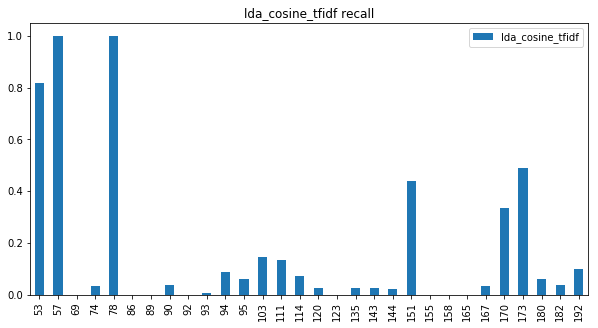

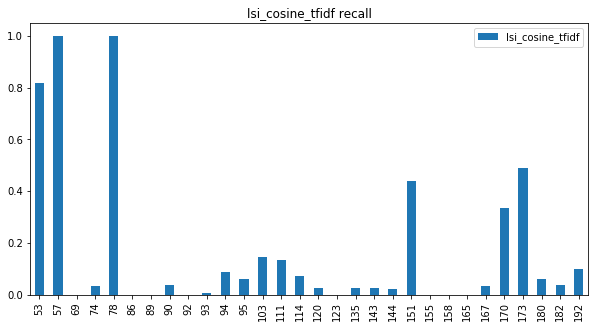

In [63]:
for model in language_models.keys():
    dicts = { setting : eval_dict['recall_1000'][setting] for setting in language_models[model] }
    ndcg_df = pd.DataFrame.from_dict(dicts) 
    ndcg_df.plot.bar(figsize=(10,5))
    plt.title(model + ' recall')
    plt.show()
    ndcg_df

In [89]:
for k, v in lsi_cosine_similarity.items():
    lsi_cosine_array = [0.0]*len(v)
    i=0
    for val in v:
        #store the scores of lsi_cosine in an array for significance testing
        lsi_cosine_array[i] = val[0][0][0]
        i+=1

In [93]:
#not sure if the testing is correct. will discuss it with you guys

In [91]:
for k, v in lda_cosine_similarity.items():
    lda_cosine_array = [0.0]*len(v)
    i=0
    for val in v:
        #store the scores of lsi_cosine in an array for significance testing
        lda_cosine_array[i] = val[0][0][0]
        i+=1

In [92]:
stats.ttest_rel(lsi_cosine_array,lda_cosine_array)

Ttest_relResult(statistic=0.36841071313803836, pvalue=0.7126450630176855)

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

#### WORD2VEC

In [41]:
#creating names, constants and files
word2vec_file = 'word2vec_model.bin'
doc2vec_file = 'doc2vec_model.doc2vec'

corpus_file = 'pyndri_corpus.mm'
dict_file='corpdict.dict'

tfidf_model_file = 'tfidf_model.model'
tfidf_corpus_file = 'tfidf_corpus.mm'

lsi_model_file = 'lsi_model.model'
lsi_corpus_file = 'lsi_corpus.mm'

lda_model_file = 'lda_model.model'
lda_corpus_file = 'lda_corpus.mm'

LSI_SHAPE = 64
LDA_SHAPE = 32
NN_LAYERS = 32

AVAILABLE_CORES = multiprocessing.cpu_count()

logging.info("Created variables")

INFO:root:Created variables


In [42]:
logging.info('Initializing word2vec.')

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

if not os.path.isfile(word2vec_file):
    #train a model if it is not present
    model = gensim.models.Word2Vec(sentences,
                                  size = NN_LAYERS,
                                  window = 5, # One-sided window size
                                  min_count = 5, # Minimum word frequency
                                  workers = AVAILABLE_CORES,
                                  sample = 1e-5, # Sub-sample threshold
                                  negative = 5, # Number of negative examples
                                  sg = True)
    model.wv.save_word2vec_format(word2vec_file, binary = True)
    
else:
    #load existing model
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file, binary = True)

INFO:root:Initializing word2vec.
INFO:gensim.models.keyedvectors:loading projection weights from word2vec_model.bin
INFO:gensim.models.keyedvectors:loaded (102844, 32) matrix from word2vec_model.bin


### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

### Task 5: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
